Import data for train/test

In [10]:
import numpy as np
import pandas as pd
x = np.load(f'/datasets/nicolas_facchinetti/processed_data/emodb/x_multif.npy').reshape(-1, 256, 256, 6)
y = np.load(f'/datasets/nicolas_facchinetti/processed_data/emodb/y_multif.npy')
metadata = pd.read_csv(f'/datasets/nicolas_facchinetti/processed_data/emodb/metadata_multif.csv')

In [11]:
x.shape

(802, 256, 256, 6)

Train test data

In [12]:
def leave_one_speaker_out(data, n=5):
    speakers = data.actor.unique()
    # random select n actors as test
    selected = np.random.choice(speakers, size=n, replace=False)
    
    myCViterator = []
    for i in selected:
        trainIndices = data[data['actor']!=i ].index.values.astype(int)
        testIndices =  data[data['actor']==i ].index.values.astype(int)
        myCViterator.append((trainIndices, testIndices))
    return myCViterator

In [13]:
indices = leave_one_speaker_out(metadata, 1)
train = indices[0][0]
test = indices[0][1]
train, test

(array([  0,   1,   2,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  23,  24,  25,  26,  27,  30,  31,
         32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
         45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
         58,  59,  60,  61,  62,  63,  64,  66,  67,  68,  69,  70,  71,
         72,  73,  74,  76,  77,  78,  81,  82,  83,  84,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 108, 109, 112, 113, 114, 116, 117, 118, 119, 120,
        121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
        135, 136, 137, 138, 139, 140, 141, 144, 145, 146, 147, 148, 149,
        152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 167, 168, 169, 170, 171, 172, 173, 176, 177, 178, 179, 180,
        181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
        194, 195, 196, 197, 198, 199, 200, 201, 202

In [14]:
x_train = x[train]
y_train = y[train]
x_test = x[test]
y_test = y[test]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((716, 256, 256, 6), (716, 7), (86, 256, 256, 6), (86, 7))

# Define a model for SER

In [15]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPool2D, InputLayer

2022-11-09 16:18:46.194695: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [21]:
input_size = (256, 256, 6)

In [22]:
model = Sequential([
    InputLayer(input_shape=input_size),
    #1st hidden layer
    Conv2D(16, (3, 3), activation='relu', padding="same"),
    MaxPool2D((2, 2)),
    #2nd hidden layer
    Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding="same"),
    MaxPool2D((2, 2)),
    # 3rd conv block
    Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    #ANN
    Flatten(),
    Dropout(0.2),
    Dense(units = 128, activation='relu'),
    Dense(units = 64, activation='relu'),
    #Output layer
    Dense(units= 7, activation='softmax'),
]) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 16)      880       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)             

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
from tensorflow.keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)

history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_test, y_test))

Epoch 1/50
23/23 [==============================] - 1s 35ms/step - loss: 0.9733 - accuracy: 0.6285 - val_loss: 1.3835 - val_accuracy: 0.5116
Epoch 2/50
23/23 [==============================] - 1s 29ms/step - loss: 0.8019 - accuracy: 0.7151 - val_loss: 1.4045 - val_accuracy: 0.5581
Epoch 3/50
23/23 [==============================] - 1s 31ms/step - loss: 0.7309 - accuracy: 0.7291 - val_loss: 1.6810 - val_accuracy: 0.4302
Epoch 4/50
23/23 [==============================] - 1s 31ms/step - loss: 0.5962 - accuracy: 0.8045 - val_loss: 1.5153 - val_accuracy: 0.5000
Epoch 5/50
23/23 [==============================] - 1s 33ms/step - loss: 0.4473 - accuracy: 0.8450 - val_loss: 1.2738 - val_accuracy: 0.5698
Epoch 6/50
23/23 [==============================] - 1s 31ms/step - loss: 0.3310 - accuracy: 0.8883 - val_loss: 1.4701 - val_accuracy: 0.5000
Epoch 7/50
23/23 [==============================] - 1s 33ms/step - loss: 0.2788 - accuracy: 0.9050 - val_loss: 2.3062 - val_accuracy: 0.4767
Epoch 8/50
23

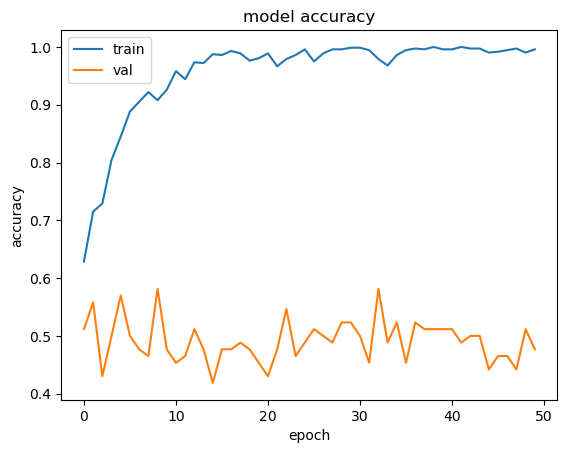

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

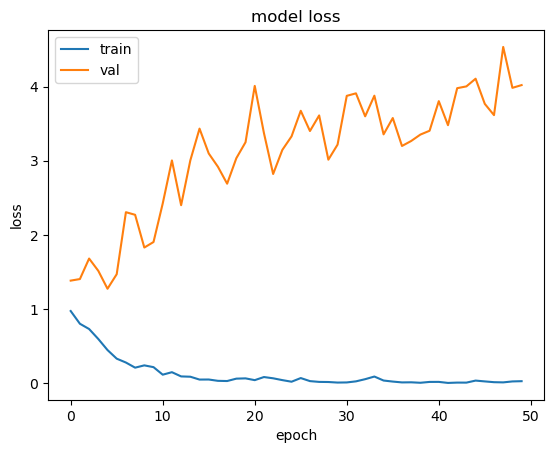

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
_, accuracy_test_original = model.evaluate(x_test, y_test)
print('Accuracy on original test data: {:4.2f}%'.format(accuracy_test_original * 100))

3/3 [==============================] - 0s 19ms/step - loss: 4.0201 - accuracy: 0.4767
Accuracy on original test data: 47.67%


Save the model for future computations

In [20]:
model.save('/datasets/nicolas_facchinetti/trained_models/EmoDB/firstCNN.h5')